In [1]:
using LightGraphs, Plots, GraphPlot, Compose, Random

In [2]:
include("ContactModels.jl")

rewire! (generic function with 1 method)

In [3]:
include("EpiSim.jl")

Main.EpiSim

In [4]:
net=covidsafe(limitmix(100^2,50),0.4)

{10000, 17131} undirected simple Int64 graph

In [5]:
function getbiggestbit(net)
    #dentify the vertices in the largest connected component of net
    cc=connected_components(net)
    bigi=0
    bign=0
    for i in 1:length(cc)
        if length(cc[i])>bign 
            bign=length(cc[i])
            bigi=i
        end
    end
    return cc[bigi]
end

getbiggestbit (generic function with 1 method)

In [6]:
net=net[getbiggestbit(net)]
ndsz=[length(neighbors(net,vert)) for vert in vertices(net)]
gplot(net, nodefillc=colorant"red",nodesize=ndsz,NODESIZE=0.10)

In [7]:
#'reasonable' parameters
epiparam=Dict()
epiparam["p0"]=1/10 #a guess - tuned to match observed data 
epiparam["q"]=1/8 #"up to" two weeks
epiparam["r0"]=1/4 #about two weeks for mild, 3-6 for severe
epiparam["nseeds"]=5 #probably too many, consider dropping.
#parameters don't change across transition point - assume about 5 undiagnosed case 
#and control the covidsafe uptake via network structure
i=8
epiparam["pop"]=100^2
#epiparam["gridsize"]=100

10000

In [8]:
netmodel=net
ndays=200
nsims=100
St,Et,It,Rt=EpiSim.episim(netmodel, epiparam, ndays, nsims)  

100.0%┣███████████████████████████████████████┫ 100/100 [00:05<00:00, 19.4 it/s]


(UInt64[0x000000000000270b 0x000000000000270b … 0x000000000000270b 0x000000000000270b; 0x000000000000270a 0x000000000000270b … 0x000000000000270b 0x000000000000270b; … ; 0x0000000000001a34 0x0000000000001b62 … 0x00000000000019a6 0x0000000000002709; 0x0000000000001a2f 0x0000000000001b61 … 0x00000000000019a4 0x0000000000002709], UInt64[0x0000000000000004 0x0000000000000005 … 0x0000000000000005 0x0000000000000005; 0x0000000000000005 0x0000000000000005 … 0x0000000000000005 0x0000000000000005; … ; 0x000000000000003e 0x0000000000000028 … 0x0000000000000017 0x0000000000000000; 0x000000000000003b 0x0000000000000022 … 0x0000000000000016 0x0000000000000000], UInt64[0x0000000000000001 0x0000000000000000 … 0x0000000000000000 0x0000000000000000; 0x0000000000000001 0x0000000000000000 … 0x0000000000000000 0x0000000000000000; … ; 0x000000000000001d 0x000000000000000f … 0x000000000000000d 0x0000000000000000; 0x000000000000001b 0x0000000000000012 … 0x000000000000000e 0x0000000000000000], UInt64[0x000000

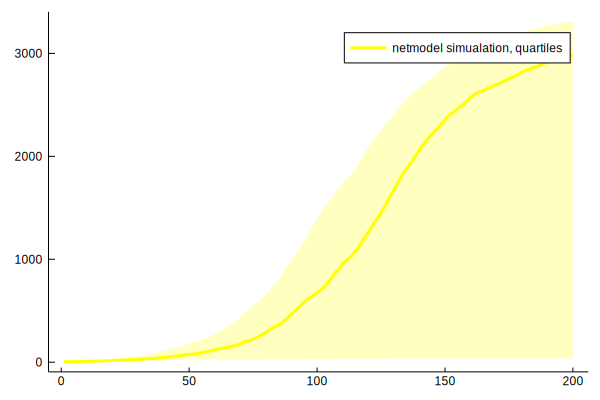

In [9]:
EpiSim.plotquantiles(epiparam["pop"] .- St,:yellow,"netmodel simualation, quartiles",0.25)

In [10]:
using CSV

In [11]:
wapop=CSV.read("WA-pop.csv")

56×3 DataFrames.DataFrame
│ Row │ Column1            │ Column2   │ Column3              │
│     │ String             │ String    │ String               │
├─────┼────────────────────┼───────────┼──────────────────────┤
│ 1   │ Perth              │ 1,874,578 │ Perth                │
│ 2   │ Bunbury            │ 71,090    │ South West           │
│ 3   │ Geraldton          │ 31,982    │ Mid West             │
│ 4   │ Kalgoorlie-Boulder │ 29,875    │ Goldfields-Esperance │
│ 5   │ Albany             │ 29,373    │ Great Southern       │
│ 6   │ Busselton          │ 25,329    │ South West           │
│ 7   │ Karratha           │ 15,828    │ Pilbara              │
│ 8   │ Broome             │ 13,984    │ Kimberley            │
│ 9   │ Port Hedland       │ 13,828    │ Pilbara              │
│ 10  │ Esperance          │ 10,421    │ Goldfields-Esperance │
⋮
│ 46  │ Jurien Bay         │ 1,425     │ Wheatbelt            │
│ 47  │ Paraburdoo         │ 1,359     │ Pilbara              │
│ 48  │ Wagin              │ 1,358     │ Wheatbelt            │
│ 49  │ Kalbarri           │ 1,349     │ Mid West             │
│ 50  │ Serpentine         │ 1,265     │ Peel                 │
│ 51  │ Binningup          │ 1,227     │ South West           │
│ 52  │ Kojonup            │ 1,165     │ Great Southern       │
│ 53  │ Boddington-Ranford │ 1,147     │ Peel                 │
│ 54  │ Fitzroy Crossing   │ 1,141     │ Kimberley            │
│ 55  │ Augusta            │ 1,109     │ South West           │
│ 56  │ Dampier            │ 1,104     │ Pilbara              │

In [12]:
wapopint=parse.(Int, replace.(wapop[:,2], r","=> ""))

56-element Array{Int64,1}:
 1874578
   71090
   31982
   29875
   29373
   25329
   15828
   13984
   13828
   10421
    8859
    7192
    6548
       ⋮
    1448
    1425
    1359
    1358
    1349
    1265
    1227
    1165
    1147
    1141
    1109
    1104

In [13]:
function buildstate(statedata,netbuilder)
    #extract the data from CSV table
    locale=statedata[:,1]
    popl=parse.(Int, replace.(statedata[:,2], r","=> ""))
    distrc=statedata[:,3]
    npl=length(popl)
    ###############
    nppl=1000 # assume 1 in 1000 people moving, on average
    ###############
    net=SimpleGraph() #empty graph
    transit=Array{Int64,2}(undef,npl,npl) #number of transits beween locale[i] and locale[j]
    for (i,town) in enumerate(locale)
        println("Adding ",town," (population: ",popl[i],")")
        #add the intralocale links
        netadd=netbuilder(popl[i]) #use the preassigned method to add the new component
        net=blockdiag(net,netadd)
        #compute the amount of transit
        for j in 1:(i-1) #number of transit between here and every other previous part
        transit[i,j] = Int(ceil(sqrt(popl[i]*popl[j])/nppl)) #number of trips proportional to geometric mean of populations
            if distrc[i]==distrc[j]
                transit[i,j]=transit[i,j]*10 #10 time higher if within the same district
            end
            transit[j,i]=transit[i,j]
        end
        transit[i,i]=0
    end
    #add the inter-locale links too --- could do it in the same (previous) loops, but this is clearer (I think)
    rr=[0; cumsum(popl)]
    for i in 1:npl
        for j in (i+1):npl
            edg1=rand(collect(rr[i]+1:rr[i+1]),transit[i,j])
            edg2=rand(collect(rr[i]+1:rr[i+1]),transit[i,j])
            for k in 1:transit[i,j]
                add_edge!(net,edg1[k],edg2[k]) #this is grossly inefficient
            end
        end
    end
    #all done
    return net, transit, locale, popl, distrc
end

buildstate (generic function with 1 method)

In [14]:
net, transit, locale, popl, distrc = buildstate(wapop[3:end,:], x -> covidsafe(nomassmix(x),0.5))

Adding Geraldton (population: 31982)
Adding Kalgoorlie-Boulder (population: 29875)
Adding Albany (population: 29373)
Adding Busselton (population: 25329)
Adding Karratha (population: 15828)
Adding Broome (population: 13984)
Adding Port Hedland (population: 13828)
Adding Esperance (population: 10421)
Adding Yanchep (population: 8859)
Adding Collie (population: 7192)
Adding Northam (population: 6548)
Adding Margaret River (population: 6392)
Adding Dunsborough (population: 6039)
Adding Newman (population: 4567)
Adding Carnarvon (population: 4426)
Adding Kununurra (population: 4341)
Adding Narrogin (population: 4274)
Adding Manjimup (population: 4213)
Adding Pinjarra (population: 3896)
Adding Katanning (population: 3702)
Adding Derby (population: 3325)
Adding Tom Price (population: 2956)
Adding Port Denison-Dongara (population: 2782)
Adding Harvey (population: 2750)
Adding Merredin (population: 2636)
Adding Denmark (population: 2558)
Adding York (population: 2548)
Adding Donnybrook (popula

({298474, 480946} undirected simple Int64 graph, [0 31 … 6 6; 31 0 … 6 6; … ; 6 6 … 0 2; 6 6 … 2 0], ["Geraldton", "Kalgoorlie-Boulder", "Albany", "Busselton", "Karratha", "Broome", "Port Hedland", "Esperance", "Yanchep", "Collie"  …  "Paraburdoo", "Wagin", "Kalbarri", "Serpentine", "Binningup", "Kojonup", "Boddington-Ranford", "Fitzroy Crossing", "Augusta", "Dampier"], [31982, 29875, 29373, 25329, 15828, 13984, 13828, 10421, 8859, 7192  …  1359, 1358, 1349, 1265, 1227, 1165, 1147, 1141, 1109, 1104], ["Mid West", "Goldfields-Esperance", "Great Southern", "South West", "Pilbara", "Kimberley", "Pilbara", "Goldfields-Esperance", "Perth", "South West"  …  "Pilbara", "Wheatbelt", "Mid West", "Peel", "South West", "Great Southern", "Peel", "Kimberley", "South West", "Pilbara"])

In [ ]:
gplot(net)

In [ ]:
plot(degree(net))

In [ ]:
net

In [ ]:
g = blockdiag(star_graph(5),path_graph(4))

In [ ]:
gplot(g)

In [ ]:
g = [star_graph(5) path_graph(4)]